In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib_venn import venn2, venn3
import os

In [2]:
# Global options

sns.set_style("white")
sns.set(font_scale=2, style="ticks")

height=15
aspect=1
x_jitter=0
y_jitter=0

# xlim=(0,10)
ylim=(-10, 10)
alpha=1
marker='.'
s=1
legend=True
legend_out=False
linewidth=0
x_jitter=0
y_jitter=0
plt.rcParams["figure.figsize"] = (20,20)

In [3]:
def merge_intervals(input_list):
    """
    Given a list of intervals, merge the overlapping ones.
    https://stackoverflow.com/questions/43600878/merging-overlapping-intervals
    """
    # sort interval
    input_list.sort(key=lambda interval: interval[0])
    merged = [input_list[0]]
    for current in input_list:
        previous = merged[-1]
        if current[0] <= previous[1]:
            previous[1] = max(previous[1], current[1])
        else:
            merged.append(current)
    return merged

In [4]:
annotation_path = "../../00_annotation/results/annotation/canonical_geneset.exons.no_repeat_overlap_and_ce_11_repeats.filtered.merged.gtf"

In [5]:
annotation = pd.read_csv(annotation_path, header=None, sep="\t")
annotation.columns = ["seqname",
                      "source",
                      "feature",
                      "start",
                      "end",
                      "score",
                      "strand",
                      "frame",
                      "attribute"]

In [6]:
annotation = annotation[annotation["feature"] == "exon"]

In [7]:
annotation.head()

,seqname,source,feature,start,end,score,strand,frame,attribute
0,MtDNA,WormBase,exon,1,55,.,+,.,"gene_id ""WBGene00014450""; transcript_id ""MTCE...."
1,MtDNA,WormBase,exon,58,111,.,+,.,"gene_id ""WBGene00014451""; transcript_id ""MTCE...."
2,MtDNA,WormBase,exon,113,549,.,+,.,"gene_id ""WBGene00010957""; transcript_id ""MTCE...."
3,MtDNA,WormBase,exon,549,783,.,+,.,"gene_id ""WBGene00010958""; transcript_id ""MTCE...."
4,MtDNA,WormBase,exon,785,840,.,+,.,"gene_id ""WBGene00014452""; transcript_id ""MTCE...."


In [8]:
annotation["gene_id"] = annotation["attribute"].str.split(";").str[0].str.replace("gene_id ", "").str.replace("\"", "")

In [9]:
annotation_short = annotation[["seqname", "start", "end", "score", "gene_id", "strand"]].copy()

In [10]:
annotation_short.head()

,seqname,start,end,score,gene_id,strand
0,MtDNA,1,55,.,WBGene00014450,+
1,MtDNA,58,111,.,WBGene00014451,+
2,MtDNA,113,549,.,WBGene00010957,+
3,MtDNA,549,783,.,WBGene00010958,+
4,MtDNA,785,840,.,WBGene00014452,+


In [11]:
annotation_short["start"] = annotation_short["start"] - 1

In [12]:
annotation_short.head()

,seqname,start,end,score,gene_id,strand
0,MtDNA,0,55,.,WBGene00014450,+
1,MtDNA,57,111,.,WBGene00014451,+
2,MtDNA,112,549,.,WBGene00010957,+
3,MtDNA,548,783,.,WBGene00010958,+
4,MtDNA,784,840,.,WBGene00014452,+


In [13]:
w = open("union_exons.bed", 'w')
for gene_group in annotation_short.groupby("gene_id"):
    seqname, score, gene_id, strand = gene_group[1].iloc[0][["seqname", "score", "gene_id", "strand"]]
    intervals = merge_intervals(gene_group[1][(["start", "end"])].values.tolist())
    for interval in intervals:
        w.write("\t".join([str(seqname), str(interval[0]), str(interval[1]), str(score), gene_id, strand + os.linesep]))
w.close()

In [14]:
union_bed = pd.read_csv("union_exons.bed", header=None, sep="\t")
union_bed.columns = ["chrom", "start", "end", "score", "gene_id", "strand"]
union_bed["length"] = union_bed["end"] - union_bed["start"]

In [15]:
gene_length = union_bed.groupby("gene_id")["length"].sum().reset_index()
gene_length.columns = ["Name", "length"]

In [16]:
gene_length.head()

,Name,length
0,I:10005952-10006427:+,476
1,I:10006437-10006683:+,247
2,I:1001335-1001573:-,239
3,I:10015772-10015842:+,71
4,I:1002040-1002265:-,226


In [17]:
gene_length.shape

(101577, 2)

In [18]:
counts = pd.read_csv("/tungstenfs/scratch/ggrossha/gypafoiv/projects/GROUP_PROJECTS/rajani/small_RNAs_Rajani/03_WAGO_IPs/results/counts/alignment_sorted_filtered_unique_mappers_reverse/counts.tsv",
                     header=0,
                     sep="\t")

In [19]:
counts.shape

(75398, 43)

In [20]:
counts.tail()

,Name,counts_Input_WAGO-1_A,counts_Input_WAGO-1_B,counts_Input_WAGO-1_C,counts_Input_WAGO-1_dpf-3_null_A,counts_Input_WAGO-1_dpf-3_null_B,counts_Input_WAGO-1_dpf-3_null_C,counts_Input_WAGO-1_P3G_A,counts_Input_WAGO-1_P3G_B,counts_Input_WAGO-1_P3G_C,...,counts_IP_WAGO-3_C,counts_IP_WAGO-3_dpf-3_null_A,counts_IP_WAGO-3_dpf-3_null_B,counts_IP_WAGO-3_dpf-3_null_C,counts_IP_WAGO-4_A,counts_IP_WAGO-4_B,counts_IP_WAGO-4_C,counts_IP_WAGO-4_dpf-3_null_A,counts_IP_WAGO-4_dpf-3_null_B,counts_IP_WAGO-4_dpf-3_null_C
75393,__no_feature,607413,1188884,770781,483275,365658,437281,458345,885449,673967,...,941102,395144,283828,211331,193428,239896,199928,64750,111611,121118
75394,__ambiguous,317,763,495,148,119,137,265,561,313,...,4202,1199,823,532,603,817,685,39,76,92
75395,__too_low_aQual,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75396,__not_aligned,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75397,__alignment_not_unique,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df = pd.merge(gene_length, counts, on="Name")

In [22]:
df.head()

,Name,length,counts_Input_WAGO-1_A,counts_Input_WAGO-1_B,counts_Input_WAGO-1_C,counts_Input_WAGO-1_dpf-3_null_A,counts_Input_WAGO-1_dpf-3_null_B,counts_Input_WAGO-1_dpf-3_null_C,counts_Input_WAGO-1_P3G_A,counts_Input_WAGO-1_P3G_B,...,counts_IP_WAGO-3_C,counts_IP_WAGO-3_dpf-3_null_A,counts_IP_WAGO-3_dpf-3_null_B,counts_IP_WAGO-3_dpf-3_null_C,counts_IP_WAGO-4_A,counts_IP_WAGO-4_B,counts_IP_WAGO-4_C,counts_IP_WAGO-4_dpf-3_null_A,counts_IP_WAGO-4_dpf-3_null_B,counts_IP_WAGO-4_dpf-3_null_C
0,I:10005952-10006427:+,476,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,I:10006437-10006683:+,247,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,I:1001335-1001573:-,239,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,I:10015772-10015842:+,71,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,I:1002040-1002265:-,226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df.shape

(75393, 44)

In [24]:
for i in df.iloc[:,2:].values:
    print(len(i))
    break

42


In [25]:
df.columns

Index(['Name', 'length', 'counts_Input_WAGO-1_A', 'counts_Input_WAGO-1_B',
       'counts_Input_WAGO-1_C', 'counts_Input_WAGO-1_dpf-3_null_A',
       'counts_Input_WAGO-1_dpf-3_null_B', 'counts_Input_WAGO-1_dpf-3_null_C',
       'counts_Input_WAGO-1_P3G_A', 'counts_Input_WAGO-1_P3G_B',
       'counts_Input_WAGO-1_P3G_C', 'counts_Input_WAGO-3_A',
       'counts_Input_WAGO-3_B', 'counts_Input_WAGO-3_C',
       'counts_Input_WAGO-3_dpf-3_null_A', 'counts_Input_WAGO-3_dpf-3_null_B',
       'counts_Input_WAGO-3_dpf-3_null_C', 'counts_Input_WAGO-4_A',
       'counts_Input_WAGO-4_B', 'counts_Input_WAGO-4_C',
       'counts_Input_WAGO-4_dpf-3_null_A', 'counts_Input_WAGO-4_dpf-3_null_B',
       'counts_Input_WAGO-4_dpf-3_null_C', 'counts_IP_WAGO-1_A',
       'counts_IP_WAGO-1_B', 'counts_IP_WAGO-1_C',
       'counts_IP_WAGO-1_dpf-3_null_A', 'counts_IP_WAGO-1_dpf-3_null_B',
       'counts_IP_WAGO-1_dpf-3_null_C', 'counts_IP_WAGO-1_P3G_A',
       'counts_IP_WAGO-1_P3G_B', 'counts_IP_WAGO-1_P3G_C'

In [26]:
df_short = df[["Name", 
              "length", 
              "counts_IP_WAGO-1_A", 
              "counts_IP_WAGO-1_B", 
              "counts_IP_WAGO-1_C",
              "counts_IP_WAGO-1_dpf-3_null_A",
              "counts_IP_WAGO-1_dpf-3_null_B",
              "counts_IP_WAGO-1_dpf-3_null_C"
             ]].copy()

In [27]:
df_short = df_short[df_short.iloc[:,2:].sum(axis=1)>10]

In [28]:
# add pseudocount
df_short.iloc[:,2:] = df_short.iloc[:,2:] + 1

In [29]:
sample_reads = df_short.iloc[:,2:].copy()
gene_len = df_short.loc[:, ['length']]
rate = sample_reads.values / gene_len.values
tpm = pd.DataFrame(rate / np.sum(rate, axis=0).reshape(1, -1) * 1e6, columns=df_short.columns[2:], index=df_short.Name)

In [30]:
new_columns = []
for name in list(tpm.columns):
    new_columns.append(name.replace("counts_",""))

In [31]:
tpm.columns = new_columns

In [32]:
tpm.head()

,IP_WAGO-1_A,IP_WAGO-1_B,IP_WAGO-1_C,IP_WAGO-1_dpf-3_null_A,IP_WAGO-1_dpf-3_null_B,IP_WAGO-1_dpf-3_null_C
Name,,,,,,
I:1015399-1015631:-,1.772316,4.823675,0.957188,2.558837,4.436810,5.279424
I:1017712-1017952:-,1.713484,2.798132,3.701658,1.649264,5.361912,2.552087
I:10201789-10202085:+,4.171209,8.325305,8.260182,9.368044,7.831642,5.522360
I:10202275-10202886:-,2.024263,0.734586,1.457679,0.974198,0.844589,2.344973
I:10238747-10239295:+,27.078669,51.589596,59.717051,2.533979,5.178299,5.975013


In [33]:
tpm = np.log2(tpm)

In [34]:
tpm["mean_IP_WAGO-1"] = tpm[["IP_WAGO-1_A", "IP_WAGO-1_B", "IP_WAGO-1_C"]].mean(axis=1)
tpm["mean_IP_WAGO-1_dpf-3_null"] = tpm[["IP_WAGO-1_dpf-3_null_A", "IP_WAGO-1_dpf-3_null_B", "IP_WAGO-1_dpf-3_null_C"]].mean(axis=1)

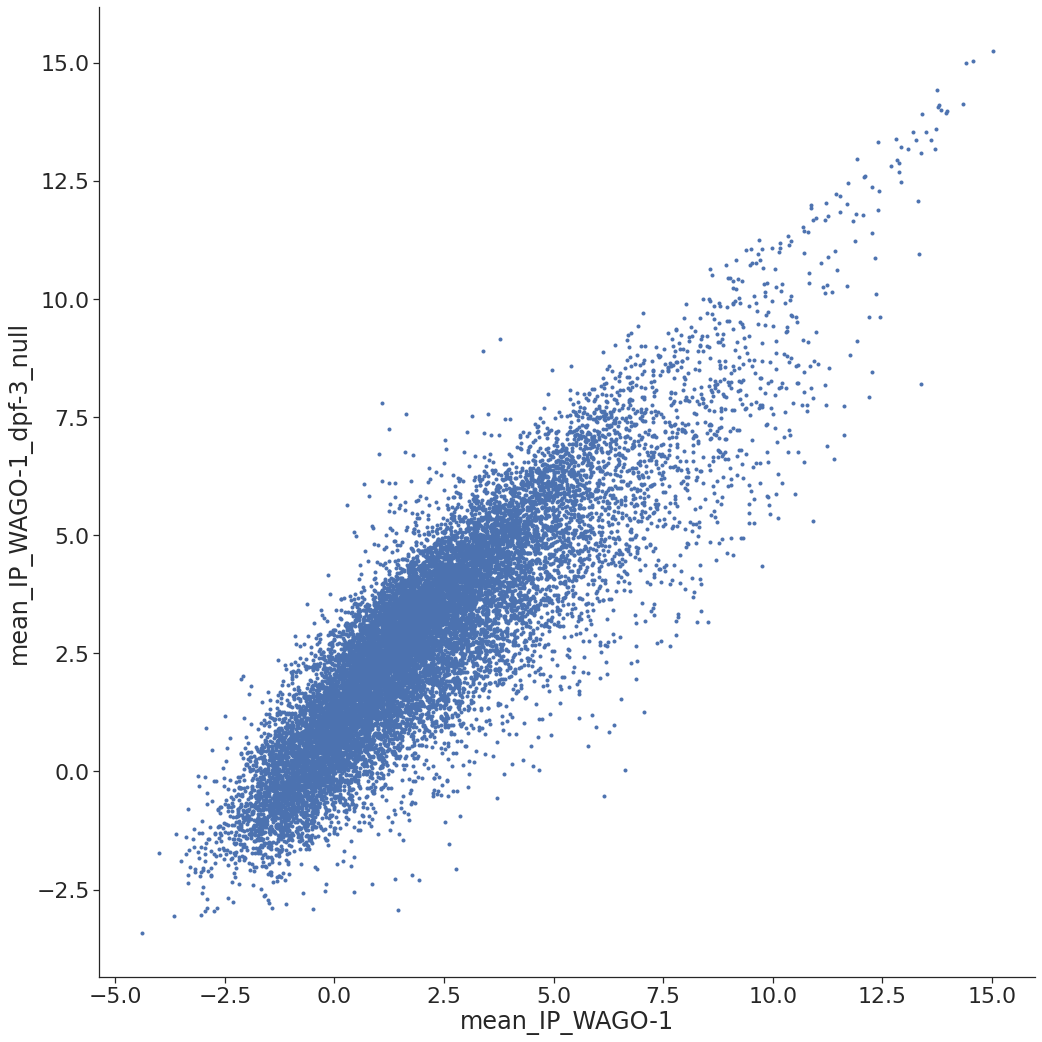

In [35]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      palette=["grey", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

# read table of DE WAGO-1 IP vs WAGO-1 dpf-3 null

In [36]:
df_wago1_wago1_dpf3 = pd.read_csv("../../03_WAGO_IPs/results/filter/DE_htseq_count__alignment_sorted_filtered_unique_mappers__reverse__IP_WAGO-1_dpf-3_null__IP_WAGO-1/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                 header=0,
                 sep="\t")

In [37]:
tpm["sig_wago1_wago1_dpf3null"] = "No"
tpm.loc[tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["logFC"]>0]["id"])), "sig_wago1_wago1_dpf3null"] = "FDR<0.05\nlogFC<0"
tpm.loc[tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_wago1_wago1_dpf3[df_wago1_wago1_dpf3["logFC"]<0]["id"])), "sig_wago1_wago1_dpf3null"] = "FDR<0.05\nlogFC>0"

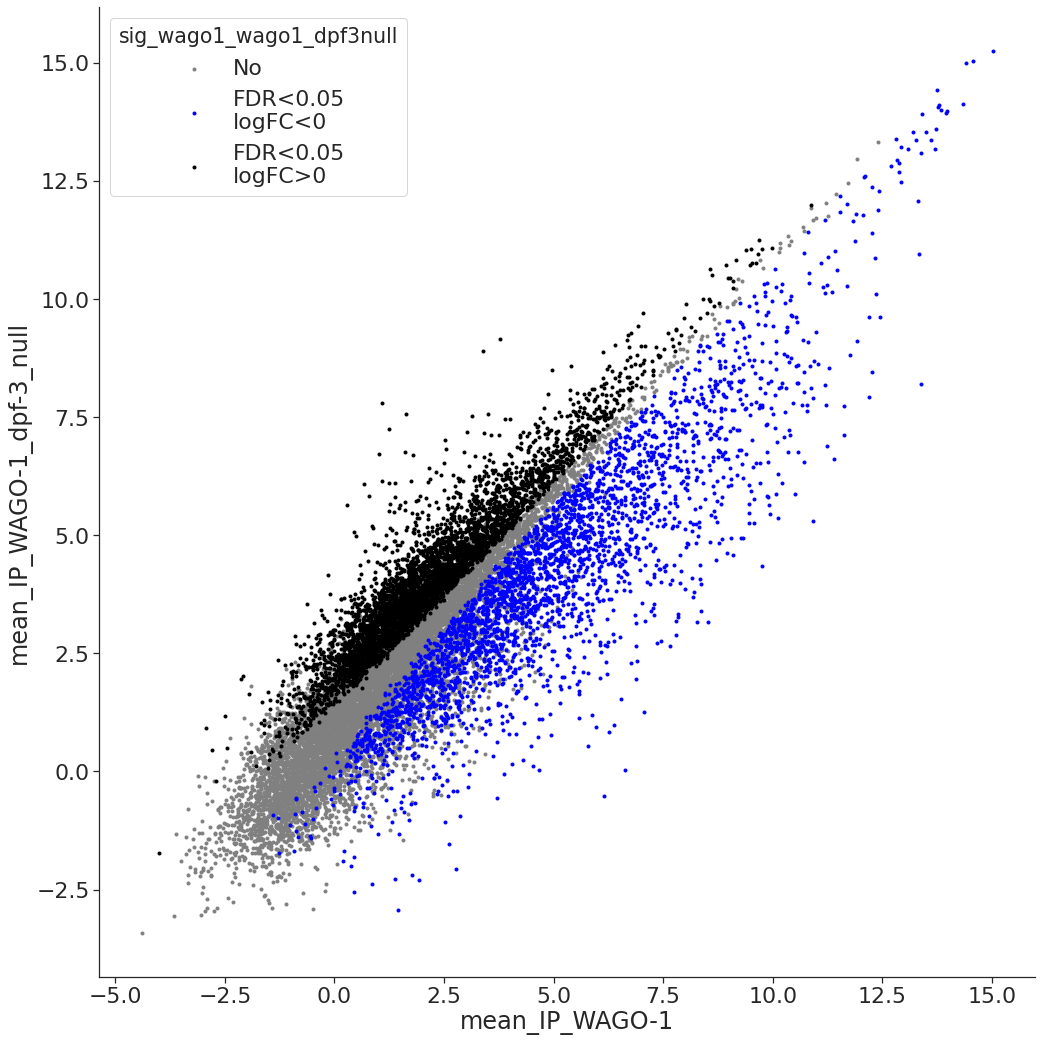

In [38]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_wago1_wago1_dpf3null",
                      hue_order=["No", "FDR<0.05\nlogFC<0", "FDR<0.05\nlogFC>0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

# read table of DE dpf-3 null over WT

In [39]:
!ls ../../01_small_RNA_seq_15_C/results/filter/DE_htseq_count__alignment_sorted_filtered_unique_mappers__reverse__WT__Dpf_3_null/DE_edgeR/final_table_FDR_low_with_gene_info.tsv

../../01_small_RNA_seq_15_C/results/filter/DE_htseq_count__alignment_sorted_filtered_unique_mappers__reverse__WT__Dpf_3_null/DE_edgeR/final_table_FDR_low_with_gene_info.tsv


In [40]:
df_dpf_3_null__over_wt = pd.read_csv("../../01_small_RNA_seq_15_C/results/filter/DE_htseq_count__alignment_sorted_filtered_unique_mappers__reverse__WT__Dpf_3_null/DE_edgeR/final_table_FDR_low_with_gene_info.tsv", 
                 header=0,
                 sep="\t")

In [41]:
tpm["sig_dpf_3_null__over_wt"] = "No"
tpm.loc[tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["logFC"]>0]["id"])), "sig_dpf_3_null__over_wt"] = "FDR<0.05\nlogFC>0"
tpm.loc[tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["FDR"]<0.05]["id"])) &
        tpm.index.isin(list(df_dpf_3_null__over_wt[df_dpf_3_null__over_wt["logFC"]<0]["id"])), "sig_dpf_3_null__over_wt"] = "FDR<0.05\nlogFC<0"

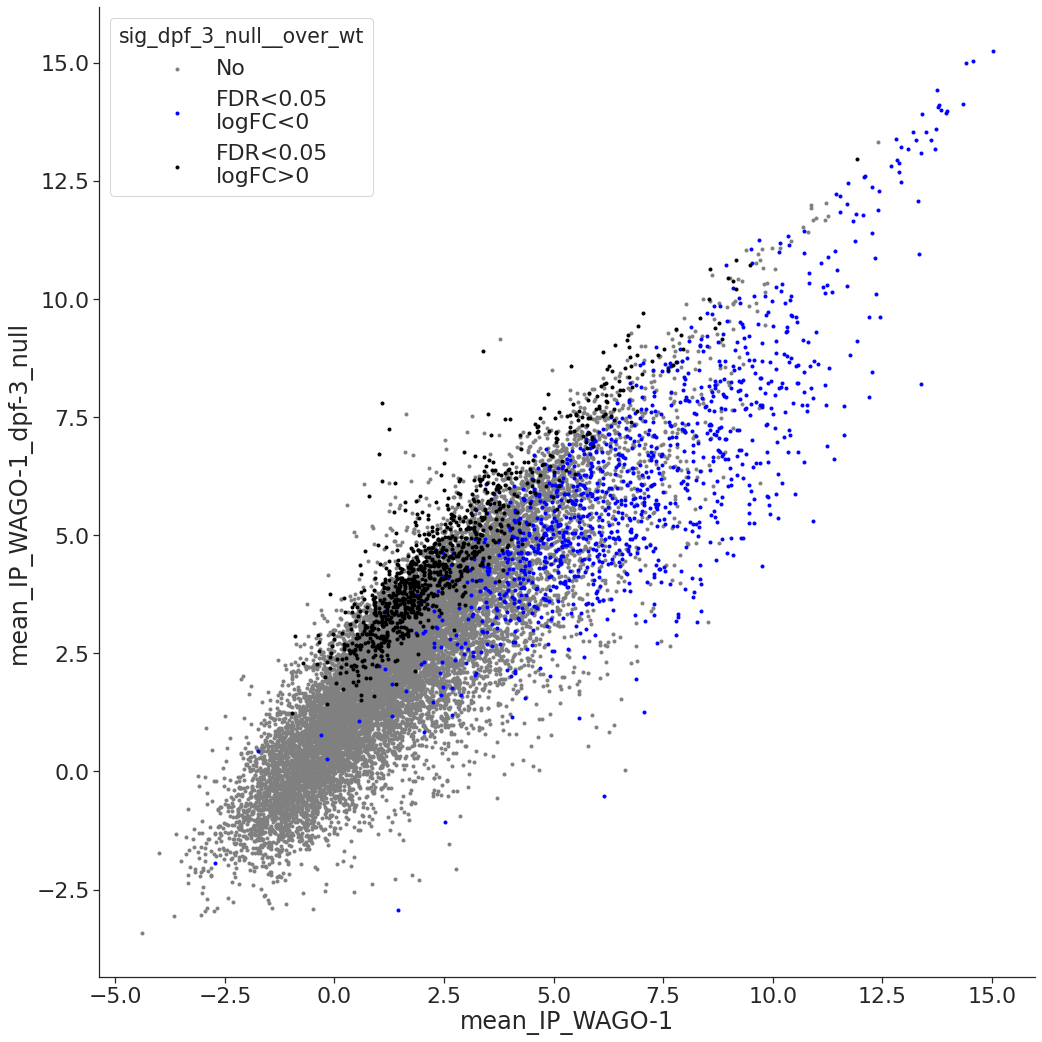

In [42]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="sig_dpf_3_null__over_wt",
                      hue_order=["No", "FDR<0.05\nlogFC<0", "FDR<0.05\nlogFC>0"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

In [43]:
pd.DataFrame(tpm[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC<0"].index).to_csv("sig_wago1_wago1_dpf3null_down.tsv", header=None, index=False)

In [44]:
pd.DataFrame(tpm[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC>0"].index).to_csv("sig_wago1_wago1_dpf3null_up.tsv", header=None, index=False)

In [45]:
pd.DataFrame(tpm[tpm["sig_dpf_3_null__over_wt"] == "FDR<0.05\nlogFC<0"].index).to_csv("sig_dpf_3_null__over_wt_down.tsv", header=None, index=False)

In [46]:
pd.DataFrame(tpm[tpm["sig_dpf_3_null__over_wt"] == "FDR<0.05\nlogFC>0"].index).to_csv("sig_dpf_3_null__over_wt_up.tsv", header=None, index=False)

In [47]:
tpm["Significant"] = "No"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC>0", "Significant"] = "wago-1 dpf-3 null specific"
tpm.loc[tpm["sig_wago1_wago1_dpf3null"] == "FDR<0.05\nlogFC<0", "Significant"] = "wago-1 specific"

No                            9166
wago-1 dpf-3 null specific    4444
wago-1 specific               3032
Name: Significant, dtype: int64

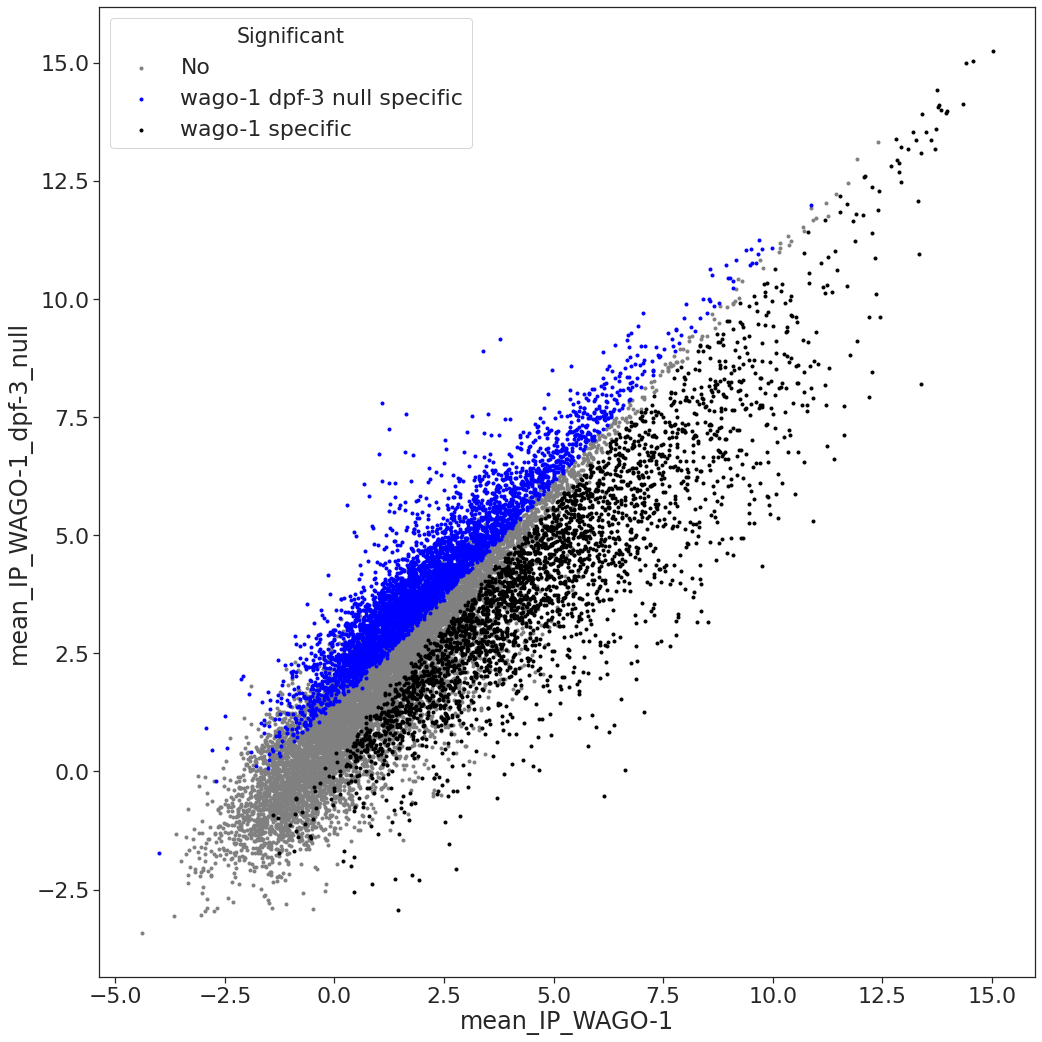

In [48]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
#                       col="annotation",
                      hue_order=["No", "wago-1 dpf-3 null specific", "wago-1 specific"],
                      palette=["grey", "blue", "black"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)

plt.savefig("scatterplot_IP_WAGO-1_IP_WAGO-1_dpf-3_null.pdf")

tpm["Significant"].value_counts()

In [49]:
tpm.loc[tpm["sig_dpf_3_null__over_wt"] == "FDR<0.05\nlogFC<0", "Significant"] = "dpf_3_null over wt downregulated"

No                                  9041
wago-1 dpf-3 null specific          4358
wago-1 specific                     2109
dpf_3_null over wt downregulated    1134
Name: Significant, dtype: int64

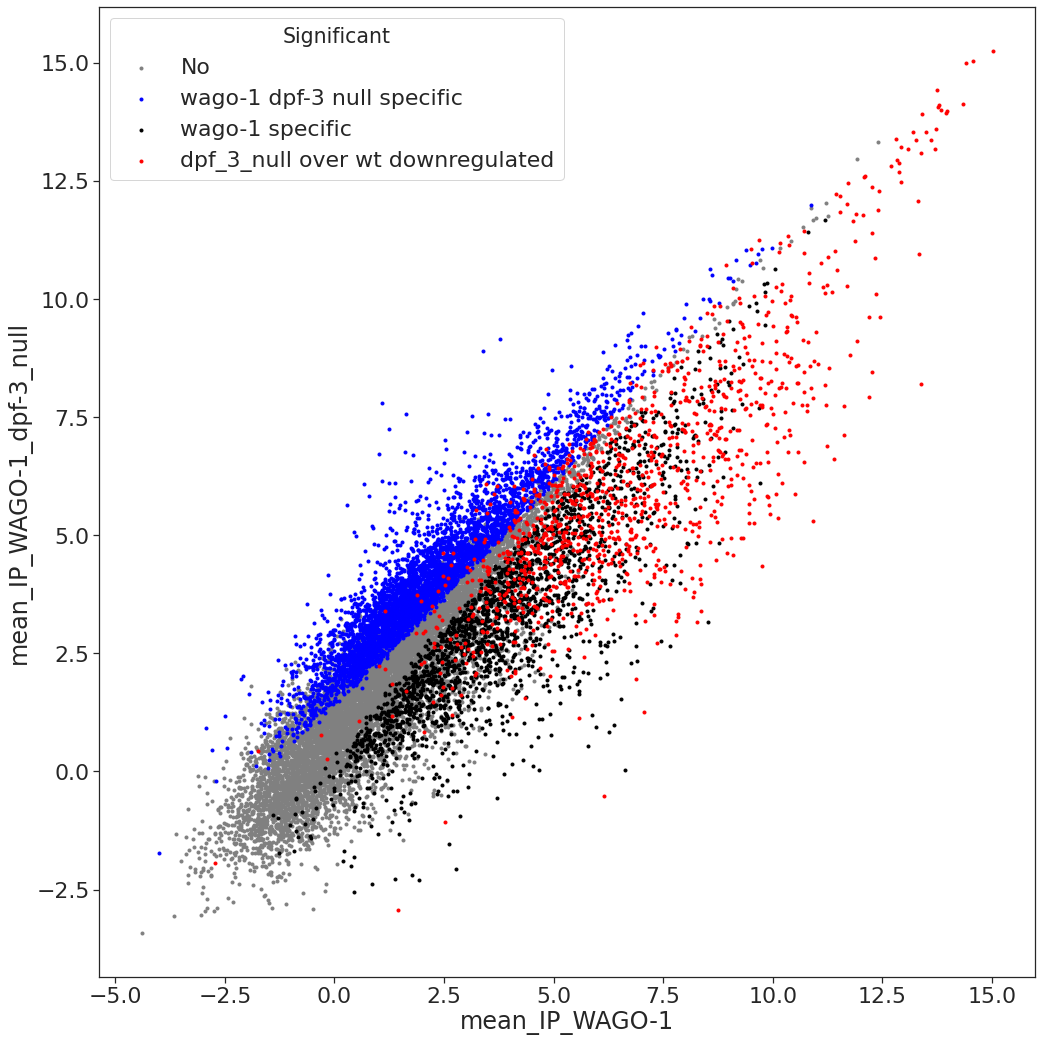

In [50]:
sns_plot = sns.lmplot(x=f"mean_IP_WAGO-1",
                      y=f"mean_IP_WAGO-1_dpf-3_null",
                      data=tpm,
                      fit_reg=False,
                      hue="Significant",
#                       col="annotation",
                      hue_order=["No", "wago-1 dpf-3 null specific", "wago-1 specific", "dpf_3_null over wt downregulated"],
                      palette=["grey", "blue", "black", "red"],
                      scatter_kws={'alpha':alpha},
                      height=height,
                      aspect=aspect,
                      x_jitter=x_jitter,
                      y_jitter=y_jitter,
                      markers=marker,
                      legend=legend,
                      legend_out = legend_out)

sns_plot = plt.gca()
sns_plot.spines['right'].set_visible(True)
sns_plot.spines['top'].set_visible(True)

plt.savefig("scatterplot_IP_WAGO-1_IP_WAGO-1_dpf-3_null_mark.pdf")

tpm["Significant"].value_counts()